# Multimodal Ollama Cookbook

<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/ollama_cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cookbook shows how you can build different multimodal RAG use cases with LLaVa on Ollama.

- Structured Data Extraction from Images
- Retrieval-Augmented Image Captioning
- Multi-modal RAG

## Setup Model

In [ ]:
!pip install llama-index-multi-modal-llms-ollama
!pip install llama-index-readers-file
!pip install unstructured
!pip install llama-index-embeddings-huggingface
!pip install llama-index-vector-stores-qdrant
!pip install llama-index-embeddings-clip

In [ ]:
from llama_index.multi_modal_llms.ollama import OllamaMultiModal

In [ ]:
mm_model = OllamaMultiModal(model="llava:13b")

## Structured Data Extraction from Images 

Here we show how to use LLaVa to extract information from an image into a structured Pydantic object.

We can do this via our `MultiModalLLMCompletionProgram`. It is instantiated with a prompt template, set of images you'd want to ask questions over, and the desired output Pydantic object.

### Load Data

Let's first load an image ad for fried chicken.

In [ ]:
from pathlib import Path
from llama_index.core import SimpleDirectoryReader
from PIL import Image
import matplotlib.pyplot as plt

input_image_path = Path("restaurant_images")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

!wget "https://docs.google.com/uc?export=download&id=1GlqcNJhGGbwLKjJK1QJ_nyswCTQ2K2Fq" -O ./restaurant_images/fried_chicken.png

# load as image documents
image_documents = SimpleDirectoryReader("./restaurant_images").load_data()

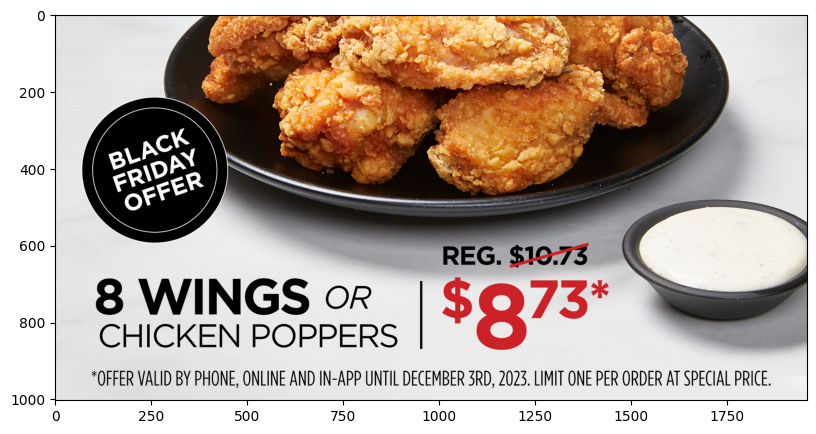

In [ ]:
# display image
imageUrl = "./restaurant_images/fried_chicken.png"
image = Image.open(imageUrl).convert("RGB")
plt.figure(figsize=(16, 5))
plt.imshow(image)

In [ ]:
from pydantic import BaseModel


class Restaurant(BaseModel):
    """Data model for an restaurant."""

    restaurant: str
    food: str
    discount: str
    price: str
    rating: str
    review: str

In [ ]:
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
{query_str}

Return the answer as a Pydantic object. The Pydantic schema is given below:

"""
mm_program = MultiModalLLMCompletionProgram.from_defaults(
    output_parser=PydanticOutputParser(Restaurant),
    image_documents=image_documents,
    prompt_template_str=prompt_template_str,
    multi_modal_llm=mm_model,
    verbose=True,
)

In [ ]:
response = mm_program(query_str="Can you summarize what is in the image?")
for res in response:
    print(res)

> Raw output:  ```
{
    "restaurant": "Buffalo Wild Wings",
    "food": "8 wings or chicken poppers",
    "discount": "20% discount on orders over $25",
    "price": "$8.73 each",
    "rating": "",
    "review": ""
}
```
('restaurant', 'Buffalo Wild Wings')
('food', '8 wings or chicken poppers')
('discount', '20% discount on orders over $25')
('price', '$8.73 each')
('rating', '')
('review', '')


## Retrieval-Augmented Image Captioning 

Here we show a simple example of a retrieval-augmented image captioning pipeline, expressed via our query pipeline syntax.

In [ ]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O tesla_2021_10k.htm
!wget "https://docs.google.com/uc?export=download&id=1THe1qqM61lretr9N3BmINc_NWDvuthYf" -O shanghai.jpg

# from llama_index import SimpleDirectoryReader
from pathlib import Path
from llama_index.readers.file import UnstructuredReader
from llama_index.core.schema import ImageDocument


loader = UnstructuredReader()
documents = loader.load_data(file=Path("tesla_2021_10k.htm"))

image_doc = ImageDocument(image_path="./shanghai.jpg")

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.core.embeddings import resolve_embed_model

embed_model = resolve_embed_model("local:BAAI/bge-m3")
vector_index = VectorStoreIndex.from_documents(
    documents, embed_model=embed_model
)
query_engine = vector_index.as_query_engine()

In [ ]:
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_pipeline import QueryPipeline, FnComponent

query_prompt_str = """\
Please expand the initial statement using the provided context from the Tesla 10K report.

{initial_statement}

"""
query_prompt_tmpl = PromptTemplate(query_prompt_str)

# MM model --> query prompt --> query engine
qp = QueryPipeline(
    modules={
        "mm_model": mm_model.as_query_component(
            partial={"image_documents": [image_doc]}
        ),
        "query_prompt": query_prompt_tmpl,
        "query_engine": query_engine,
    },
    verbose=True,
)
qp.add_chain(["mm_model", "query_prompt", "query_engine"])
rag_response = qp.run("Which Tesla Factory is shown in the image?")

> Running module mm_model with input: 
prompt: Which Tesla Factory is shown in the image?

> Running module query_prompt with input: 
initial_statement:  The image you've provided is a photograph of the Tesla Gigafactory, which is located in Shanghai, China. This facility is one of Tesla's large-scale production plants and is used for manufacturing el...

> Running module query_engine with input: 
input: Please expand the initial statement using the provided context from the Tesla 10K report.

 The image you've provided is a photograph of the Tesla Gigafactory, which is located in Shanghai, China. Thi...



In [ ]:
print(f"> Retrieval Augmented Response: {rag_response}")

> Retrieval Augmented Response: The Gigafactory Shanghai in China is an important manufacturing facility for Tesla. It was established to increase the affordability of Tesla vehicles for customers in local markets by reducing transportation and manufacturing costs and eliminating the impact of unfavorable tariffs. The factory allows Tesla to access high volumes of lithium-ion battery cells manufactured by their partner Panasonic, while achieving a significant reduction in the cost of their battery packs. Tesla continues to invest in Gigafactory Shanghai to achieve additional output. This factory is representative of Tesla's plan to improve their manufacturing operations as they establish new factories, incorporating the learnings from their previous ramp-ups.


In [ ]:
rag_response.source_nodes[1].get_content()

'For example, we are currently constructing Gigafactory Berlin under conditional permits in anticipation of being granted final permits. Moreover, we will have to establish and ramp production of our proprietary battery cells and packs at our new factories, and we additionally intend to incorporate sequential design and manufacturing changes into vehicles manufactured at each new factory. We have limited experience to date with developing and implementing manufacturing innovations outside of the Fremont Factory and Gigafactory Shanghai. In particular, the majority of our design and engineering resources are currently located in California. In order to meet our expectations for our new factories, we must expand and manage localized design and engineering talent and resources. If we experience any issues or delays in meeting our projected timelines, costs, capital efficiency and production capacity for our new factories, expanding and managing teams to implement iterative design and prod

## Multi-Modal RAG

We index a set of images and text using a local CLIP embedding model. We can index them jointly via our `MultiModalVectorStoreIndex` 

**NOTE**: The current implementation blends both images and text. You can and maybe should define separate indexes/retrievers for images and text, letting you use separate embedding/retrieval strategies for each modality).


#### Load Data

If the `wget` command below doesn't work, manually download and unzip the file [here](https://drive.google.com/file/d/1qQDcaKuzgRGuEC1kxgYL_4mx7vG-v4gC/view?usp=sharing).

In [ ]:
!wget "https://drive.usercontent.google.com/download?id=1qQDcaKuzgRGuEC1kxgYL_4mx7vG-v4gC&export=download&authuser=1&confirm=t&uuid=f944e95f-a31f-4b55-b68f-8ea67a6e90e5&at=APZUnTVZ6n1aOg7rtkcjBjw7Pt1D:1707010667927" -O mixed_wiki.zip

In [ ]:
!unzip mixed_wiki.zip

In [ ]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O ./mixed_wiki/tesla_2021_10k.htm

### Build Multi-Modal Index

This is a special index that jointly indexes both text documents and image documents.

We use a local CLIP model to embed images/text.

In [ ]:
from llama_index.core.indices.multi_modal.base import (
    MultiModalVectorStoreIndex,
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.embeddings.clip import ClipEmbedding

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

image_embed_model = ClipEmbedding()

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    image_embed_model=image_embed_model,
)

# Save it
# index.storage_context.persist(persist_dir="./storage")

# # Load it
# from llama_index import load_index_from_storage

# storage_context = StorageContext.from_defaults(
#     vector_store=text_store, persist_dir="./storage"
# )
# index = load_index_from_storage(storage_context, image_store=image_store)

In [ ]:
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    multi_modal_llm=mm_model, text_qa_template=qa_tmpl
)

query_str = "Tell me more about the Porsche"
response = query_engine.query(query_str)

In [ ]:
print(str(response))

 The image shows a Porsche sports car displayed at an auto show. It appears to be the latest model, possibly the Taycan Cross Turismo or a similar variant, which is designed for off-road use and has raised suspension. This type of vehicle combines the performance of a sports car with the utility of an SUV, allowing it to handle rougher terrain and provide more cargo space than a traditional two-door sports car. The design incorporates sleek lines and aerodynamic elements typical of modern electric vehicles, which are often associated with luxury and high performance.


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

**Node ID:** 3face2c9-3b86-4445-b21e-5b7fc9683adb<br>**Similarity:** 0.8281288080117539<br>**Text:** === Porsche Mission E Cross Turismo ===
The Porsche Mission E Cross Turismo previewed the Taycan Cross Turismo, and was presented at the 2018 Geneva Motor Show. The design language of the Mission E...<br>

**Node ID:** ef43aa15-30b6-4f0f-bade-fd91f90bfd0b<br>**Similarity:** 0.8281039313464207<br>**Text:** The Porsche Taycan is a battery electric saloon and shooting brake produced by German automobile manufacturer Porsche. The concept version of the Taycan, named the Porsche Mission E, debuted at the...<br>

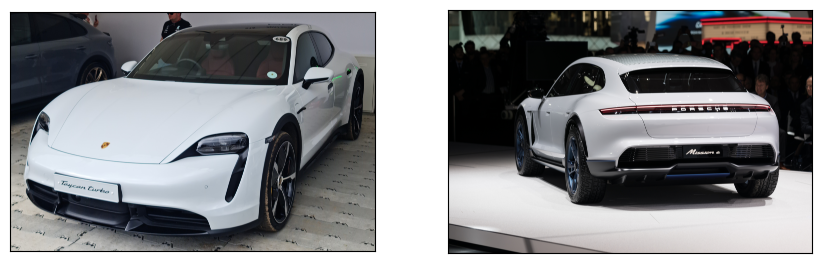

In [ ]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)